# Autoencoders
# IV. Denoising

У автоэнкодеров кроме генерации и изменения изображений существуют и другие практические применения, одно из которых мы сейчас и реализуем.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть loss-функция AE останется той же (MSE между реальной картинкой и выданной), но на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0" height="150"></a>

В этом блокноте мы будем работать с датасетом лиц, на котором обучали AE в [первом блокноте](https://github.com/ivantipow/Autoencoders/blob/main/1_Vanilla_Autoencoder.ipynb). 

## Содержание

- [Подготовка окружения](#environment)

- [Подготовка данных](#data)

- [Архитектура модели](#architecture_denoise)

- [Обучение](#train_ade)

    - [Функции для обучения ADE](#train_ade_func)

    - [Обучение ADE](#ade_train)

- [Тестируем denoising](#test_denoise)

<a id='environment'></a>
## Подготовка окружения

Импортируем необходимые библиотеки

In [1]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
from time import time
import seaborn as sns
import os
import pickle
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects as path_effects
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

[Reproducibility (Pytorch):](https://pytorch.org/docs/stable/notes/randomness.html)

In [2]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
!nvidia-smi

Fri Jan  7 15:29:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Далее будем сохранять лучшие модели

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

DATA_DIR = '/content/gdrive/MyDrive/autoencoders/weights'

Mounted at /content/gdrive/


<a id='data'></a>
## Подготовка данных

In [6]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                  images_name="lfw-deepfunneled",
                  dx=80, dy=80,
                  dimx=64, dimy=64
                  ):

    # Скачать, если не существует
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system(
            "wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(
            "wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # Считываем атрибуты
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(
        df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # Считываем фотографии
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append(
                    {'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)

    # Mass-merge
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # Предобработка изображений
    all_photos = df['photo_path'].apply(skimage.io.imread)\
        .apply(lambda img: img[dy:-dy, dx:-dx])\
        .apply(lambda img: resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [7]:
# Загрузим данные
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Теперь возьмем наш датасет с лицами и сделаем его копию с шумом.

In [8]:
# Добавим шум на изображения
noise_factor = 0.2
noise = noise_factor * np.random.normal(loc=0.0,
                                        scale=1.0,
                                        size=data.shape
                                        ).astype('float32')
data_noisy = np.copy(data) + noise  # Копия датасета с шумом

# Разделим на обучение и валидацию
X_train, X_val, Y_train, Y_val = train_test_split(data_noisy,
                                                  data,
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  random_state=42
                                                  )

# Приведем данные к форме (BatchSize x C x H x W)
X_train_CHW = np.rollaxis(X_train, 3, 1)
Y_train_CHW = np.rollaxis(Y_train, 3, 1)
X_val_CHW = np.rollaxis(X_val, 3, 1)
Y_val_CHW = np.rollaxis(Y_val, 3, 1)

# Объединим исходные (чистые) и зашумленные изображения
# на тесте и валидации в датасеты
train_dataset = list(zip(X_train_CHW, Y_train_CHW))
val_dataset = list(zip(X_val_CHW, Y_val_CHW))

# Создадим dataloader'ы
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
print(f'Размер обучающего датасета: {len(train_loader.dataset)}.')
print(f'Размер тестового датасета: {len(val_loader.dataset)}.')

Размер обучающего датасета: 10514.
Размер тестового датасета: 2629.


Посмотрим на то, как выглядят наши фотографии после добавления шума 🖼

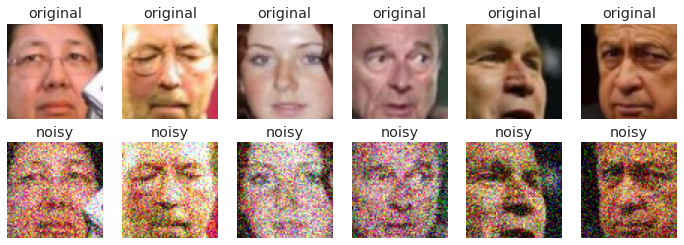

In [10]:
# Приведем данные к соответствующей форме для подачи в imshow
x_val, y_val = next(iter(val_loader))
x_val = np.clip(x_val.numpy(), 0, 1)
y_val = np.clip(y_val.numpy(), 0, 1)


plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(y_val[i+7], 0, 3))
    plt.title('original')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i+7], 0, 3))
    plt.title('noisy')

plt.show()

<a id='architecture_denoise'></a>
## Архитектура модели

<img src="https://miro.medium.com/max/2400/0*qgxeODdkcdMIfR--.png" alt="Denoise"  height="350">

Picture from: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

Будем использовать архитектуру такую же, как у автоэнкодера из [первого блокнота](https://github.com/ivantipow/Autoencoders/blob/main/1_Vanilla_Autoencoder.ipynb). Увеличим только размерность латентного пространства

In [11]:
dim_code = 1024


class AutoDencoder(nn.Module):
    """Autoencoder for Denoising."""

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Feature Extractor
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, dilation=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=5, stride=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Flatten(),

            # FC
            nn.Linear(in_features=256*4*4, out_features=256*4),
            nn.ReLU(),
            nn.Linear(in_features=256*4, out_features=dim_code)
        )

        self.decoder = nn.Sequential(
            # FC
            nn.Linear(in_features=dim_code, out_features=256*4),
            nn.ReLU(),
            nn.Linear(in_features=256*4, out_features=256*4*4),

            nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),

            # Feature Extractor
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=5, stride=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=5,
                               stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward проход автоэнкодера
        latent_code - латентное представление картинки
        reconstruction - полученная реконструкция изображения
        """

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction

In [12]:
ade = AutoDencoder().to(DEVICE)

# Архитектура энкодера
torchsummary.summary(ade, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 30, 30]         102,464
       BatchNorm2d-5           [-1, 64, 30, 30]             128
              ReLU-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 30, 30]          73,856
       BatchNorm2d-8          [-1, 128, 30, 30]             256
              ReLU-9          [-1, 128, 30, 30]               0
        MaxPool2d-10          [-1, 128, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         295,168
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             ReLU-13          [-1, 256, 15, 15]               0
           Conv2d-14            [-1, 25

<a id='train_ade'></a>
## Обучение

<a id='train_ade_func'></a>
### Функции для обучения ADE

In [13]:
def train_model(train_loader, val_loader, model, model_name, epochs,
                criterion, optimizer, scheduler):
    """Обучить Autoencoder для решения задачи denoising'а"""

    best_loss = 9999999

    since = time()

    # Loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(42 + 3 * epoch)

        # Train-phase
        model.train()
        train_losses_per_epoch = []

        for x_batch, y_batch in train_loader:

            x_batch = x_batch.float().to(DEVICE)
            y_batch = y_batch.float().to(DEVICE)

            reconstruction = model(x_batch)
            loss = criterion(reconstruction, y_batch)

            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.detach().cpu().item())

            optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))

        # Test-phase
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:

                x_batch = x_batch.float().to(DEVICE)
                y_batch = y_batch.float().to(DEVICE)

                reconstruction = model(x_batch)
                loss = criterion(reconstruction, y_batch).detach().cpu().item()

                test_losses_per_epoch.append(loss)

        test_losses.append(np.mean(test_losses_per_epoch))

        scheduler.step()

        # Сохранить лучшую модель
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(),
                       os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since

        # Сохранить текущую модель
        torch.save(model.state_dict(),
                   os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))

        # Visualize tools
        clear_output(wait=True)

        original = np.clip(y_batch.cpu().numpy(), 0, 1)
        noisy = np.clip(x_batch.cpu().numpy(), 0, 1)
        reconstuct = np.clip(reconstruction.cpu().numpy(), 0, 1)

        plt.figure(figsize=(10, 12))
        for i in range(5):
            plt.subplot(6, 5, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(original[i], 0, 3))
            plt.title('original')

            plt.subplot(6, 5, i+1+5)
            plt.axis("off")
            plt.imshow(np.rollaxis(noisy[i], 0, 3))
            plt.title('noisy')

            plt.subplot(6, 5, i+1+10)
            plt.axis("off")
            plt.imshow(np.rollaxis(reconstuct[i], 0, 3))
            plt.title('denoisy')

        plt.subplot(2, 1, 2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="test_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - test loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show()

    # Final
    print(
        f'Training is done! Best epoch {best_epoch}, best time {best_time}, best test loss {best_loss}, best train loss {best_t_loss}')

    # Загрузить лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(
        DATA_DIR, 'best_' + model_name + '.pth')))

    return model

<a id='ade_train'></a>
### Обучение ADE

Зададим функцию потерь, модель, оптимизатор и шедулер

In [15]:
criterion = F.mse_loss

ade = AutoDencoder().to(DEVICE)

optimizer = optim.AdamW(params=ade.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=33, gamma=0.1)

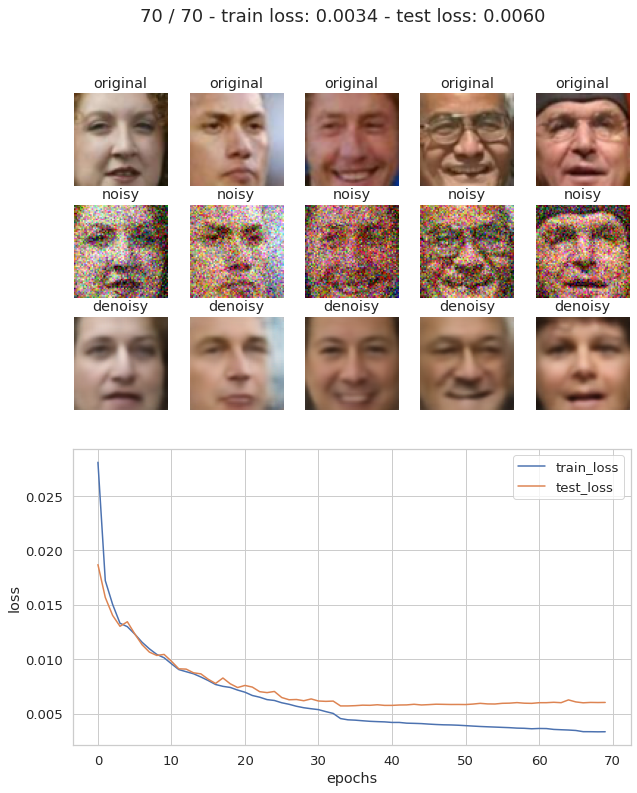

100%|██████████| 70/70 [3:34:54<00:00, 184.21s/it]

Training is done! Best epoch 34, best time 6267.361203193665, best test loss 0.0057206052865478255, best train loss 0.004560442809297732


In [16]:
epochs = 70
ade = train_model(train_loader, val_loader, ade, 'denois', epochs, criterion,
                  optimizer, scheduler)

Начиная с 35 эпохи, модель стала переобучаться. Для дальнейшей работы будем использовать параметры сети соответствующие минимальному значению функции потерь на валидационной выборке (34 эпоха).

<a id='test_denoise'></a>
## Тестируем denoising

In [17]:
# Загрузим обученный автоэнкодер
ade = AutoDencoder().to(DEVICE)
ade.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_denois.pth')))

<All keys matched successfully>

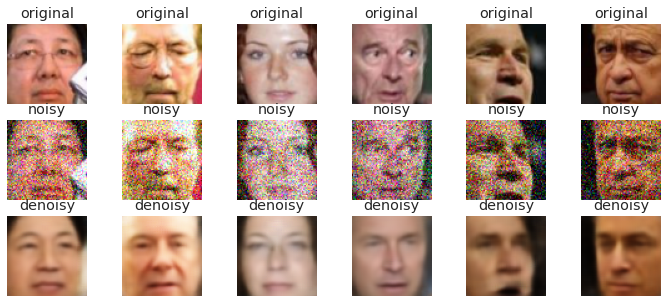

In [29]:
x_val, y_val = next(iter(val_loader))
y_val = np.clip(y_val.numpy(), 0, 1)

with torch.no_grad():
    x_reconstr = ade(x_val.float().to(DEVICE)).cpu().numpy()

x_reconstr = np.clip(x_reconstr, 0, 1)
x_val = np.clip(x_val.numpy(), 0, 1)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(y_val[i+7], 0, 3))
    plt.title('original')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i+7], 0, 3))
    plt.title('noisy')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('denoisy')

plt.show()

Видим, что автоэнкодеру удалось побороть шумы на изображениях, несмотря на то, что подаваемые на вход ему картинки были сильно зашумлены. Также вполне ожидаемо, что восстановленные изображения заметно уступают в детализации исходным не зашумленным картинкам. У этого две причины. Во-первых, сами входные изображения несут в себе меньше информации из-за наличия шума (энтропия на noisy-картинках выше, чем на original). А во-вторых, сами автоэнкодеры склонны к "усреднению" своих предсказаний (это было видно и в предыдущих блокнотах), что сказывается на детализации реконструированных изображений.